# Exploratory Data Analysis
We first want to understand how data is shaped and how we can intreract with it. Then we want to understnd what's the goal of the competition.

Sources:
- https://github.com/google-research-datasets/tpu_graphs
- https://arxiv.org/abs/2308.13490

## Data Shape
The data is divided in two parts:
- `layout:*`
- `tile:xla`
  
Each of them can be considered as a graph representing a TPU/NN model (or a subpart of it) which needs to be trained, and each of them comes in a number of different configurations, each with the runtime that the model takes to be trained  (target) given that model and that specific configuration. 
This two parts have different features and are basically two distinct problems, but in both of them the goal is to predict which of the different configurations is the fastest to run.

How many graphs of each kind do we have?

In [1]:
import os
import pandas as pd
import numpy as np

for (dirpath, dirnames, filenames) in os.walk('data/tpugraphs'):
    depth = dirpath.count('/')
    dirname = dirpath.split('/')[-1]
    if len(filenames) == 0:
        print('  '*depth + '-'+ dirname)
    else:
        print('  '*depth + '-'+ dirname + ': ' + str(len(filenames)))

  -tpugraphs
    -tile
      -xla
        -train: 5709
        -test: 844
        -valid: 676
    -layout
      -xla
        -default
          -train: 61
          -test: 8
          -valid: 7
        -random
          -train: 69
          -test: 8
          -valid: 7
      -nlp
        -default
          -train: 198
          -test: 17
          -valid: 20
        -random
          -train: 207
          -test: 17
          -valid: 20


We can now look at how each sample (graph) is structered, remeber that whe are talking of with `n` nodes, `m` edges and `c` possible configurations. Each of them is a dictionary of numpy arrays, where:
- `edge_index` $2 \times m$: it's the Adjacency List of edges, where if the i-th entry is [u,v] than it means that there is a directed edge from u to v, **meaning** that the node $u$ consumes the output of node $v$.
- `node_opcode` (n, ): The uth entry stores the op-code for node u, referring to which operation is this node performing (later we'll map this integer code to the actual operation).
- `node_feat` (n, 140): The uth row contains the feature vector for node u. This "features" describe for example the dimensions sizes of the operation, or if it's a convolution the size of window, stride, padding etc...
- `config_feat` (c, 24): with row j containing the (graph-level) configuration feature vector. This features are instead specific to the configuration, and are like ???

Now let's look at an example:

In [2]:
load = lambda file: dict(np.load(file))

example=load("data/tpugraphs/tile/xla/train/mlperf_ssd_2_shard_batch_8_fast_epoch_fe3d25cfab3c3aa.npz")
example

{'node_feat': array([[0., 0., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'node_opcode': array([63, 11, 63, 11, 63, 63, 41, 63, 41, 26, 24, 13, 83, 63, 63, 63, 41],
       dtype=uint8),
 'edge_index': array([[ 1,  0],
        [ 3,  2],
        [ 6,  1],
        [ 6,  5],
        [ 8,  3],
        [ 8,  7],
        [ 9,  6],
        [ 9,  8],
        [11, 10],
        [12,  4],
        [12,  9],
        [12, 11],
        [16, 12],
        [16, 13],
        [16, 14],
        [16, 15]]),
 'config_feat': array([[25., 25.,  1., ...,  0.,  0.,  0.],
        [ 2.,  1.,  1., ...,  0.,  0.,  0.],
        [ 7.,  1.,  1., ...,  0.,  0.,  0.],
        ...,
        [ 9., 25.,  1., ...,  0.,  0.,  0.],
        [25.,  9.,  1., ...,  0.,  0.,  0.],
        [13., 25.,  1., ...,  0.,  0.,  0.]], dtype=f

We can visualize one of this graphs: remember that an edge from u to v means that **the output of v is consumed by u**. This is a bit counter intuitive at first, but you can imagine it as a dependency graph (maybe).

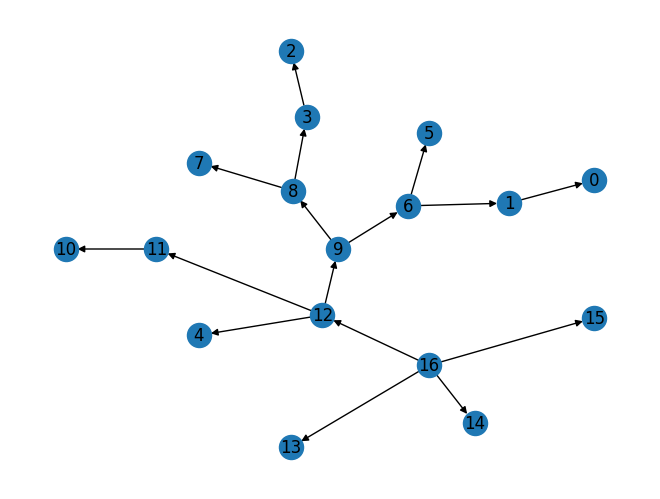

In [3]:
import networkx as nx

adj_list = example['edge_index']

adj_list_nx_readable = [np.array2string(adj_list[m])[1:-1] for m in range(adj_list.shape[0])]

graph = nx.parse_adjlist(adj_list_nx_readable, create_using=nx.DiGraph)

pos = nx.nx_agraph.graphviz_layout(graph, prog="twopi", args="")
nx.draw(graph, pos, with_labels=True)

Now we can attach the operation performed by each node and visualize it.

Notice that all the nodes without outgoing edges are the ones where the computation starts and they are all "parameter" (aka input) or "constant". Then we see that instead the "real" operations inside are in this case "bitcast", "fusion", "convolution", "broadcast", "select".

In [4]:
OPCODE_MAP = {
    1: 'abs',  # Computes the absolute value of the input.
    2: 'add',  # Adds two input values.
    3: 'add-dependency',  # Specifies a dependency between operations.
    4: 'after-all',  # Specifies that an operation should execute after all previous operations are completed.
    5: 'all-reduce',  # Performs an all-reduce operation, often used for distributed computing.
    6: 'all-to-all',  # Performs an all-to-all communication operation.
    7: 'atan2',  # Computes the element-wise arctangent of two input values.
    8: 'batch-norm-grad',  # Computes gradients for batch normalization.
    9: 'batch-norm-inference',  # Performs batch normalization during inference.
    10: 'batch-norm-training',  # Performs batch normalization during training.
    11: 'bitcast',  # Converts the input to a different data type using bit manipulation.
    12: 'bitcast-convert',  # Converts data types using bit manipulation.
    13: 'broadcast',  # Broadcasts input values to match the shape of another tensor.
    14: 'call',  # Calls a function or operation.
    15: 'ceil',  # Computes the ceiling of input values (rounds up to the nearest integer).
    16: 'cholesky',  # Computes the Cholesky decomposition of a matrix.
    17: 'clamp',  # Clamps input values to a specified range.
    18: 'collective-permute',  # Performs a collective permutation operation.
    19: 'count-leading-zeros',  # Counts the number of leading zeros in binary representation.
    20: 'compare',  # Compares input values element-wise.
    21: 'complex',  # Creates complex numbers from real and imaginary parts.
    22: 'concatenate',  # Concatenates tensors along a specified axis.
    23: 'conditional',  # Implements a conditional operation.
    24: 'constant',  # Defines a constant tensor with a specified value.
    25: 'convert',  # Converts data types.
    26: 'convolution',  # Performs convolution operation, often used in image processing.
    27: 'copy',  # Copies data from one location to another.
    28: 'copy-done',  # Indicates the completion of a data copy operation.
    29: 'copy-start',  # Indicates the start of a data copy operation.
    30: 'cosine',  # Computes the cosine of input values.
    31: 'custom-call',  # Invokes a custom-defined function or operation.
    32: 'divide',  # Divides one input value by another.
    33: 'domain',  # Defines the domain or context for an operation.
    34: 'dot',  # Computes the dot product of two tensors.
    35: 'dynamic-slice',  # Dynamically slices a tensor based on input indices.
    36: 'dynamic-update-slice',  # Dynamically updates a slice of a tensor.
    37: 'exponential',  # Computes the exponential of input values.
    38: 'exponential-minus-one',  # Computes exp(x) - 1 for input values.
    39: 'fft',  # Computes the Fast Fourier Transform of input data.
    40: 'floor',  # Computes the floor of input values (rounds down to the nearest integer).
    41: 'fusion',  # Performs fusion of multiple operations into a single operation.
    42: 'gather',  # Gathers values from a tensor based on input indices.
    43: 'get-dimension-size',  # Retrieves the size of a specific dimension of a tensor.
    44: 'set-dimension-size',  # Sets the size of a specific dimension of a tensor.
    45: 'get-tuple-element',  # Retrieves an element from a tuple.
    46: 'imag',  # Retrieves the imaginary part of complex numbers.
    47: 'infeed',  # Performs an infeed operation, often used in data pipelines.
    48: 'iota',  # Generates a range of values from a starting value.
    49: 'is-finite',  # Checks if input values are finite.
    50: 'log',  # Computes the natural logarithm of input values.
    51: 'log-plus-one',  # Computes log(x + 1) for input values.
    52: 'and',  # Performs a bitwise AND operation element-wise.
    53: 'not',  # Performs a bitwise NOT operation element-wise.
    54: 'or',  # Performs a bitwise OR operation element-wise.
    55: 'xor',  # Performs a bitwise XOR operation element-wise.
    56: 'map',  # Applies a function or operation to each element of a tensor.
    57: 'maximum',  # Computes the element-wise maximum of two input values.
    58: 'minimum',  # Computes the element-wise minimum of two input values.
    59: 'multiply',  # Multiplies two input values element-wise.
    60: 'negate',  # Negates input values element-wise.
    61: 'outfeed',  # Performs an outfeed operation, often used in data pipelines.
    62: 'pad',  # Pads a tensor with zeros or a specified value.
    63: 'parameter',  # Specifies a parameter for an operation.
    64: 'partition-id',  # Retrieves the ID of a partition.
    65: 'popcnt',  # Computes the population count (number of set bits) in binary representation.
    66: 'power',  # Computes the power (exponentiation) of input values.
    67: 'real',  # Retrieves the real part of complex numbers.
    68: 'recv',  # Receives data as part of a communication operation.
    69: 'recv-done',  # Indicates the completion of a receive operation.
    70: 'reduce',  # Performs a reduction operation.
    71: 'reduce-precision',  # Specifies the precision for reduction operations.
    72: 'reduce-window',  # Performs reduction with a specified window size.
    73: 'remainder',  # Computes the remainder of division between two input values.
    74: 'replica-id',  # Retrieves the ID of a replica.
    75: 'reshape',  # Reshapes a tensor to a specified shape.
    76: 'reverse',  # Reverses the order of elements in a tensor.
    77: 'rng',  # Initializes a random number generator.
    78: 'rng-get-and-update-state',  # Retrieves and updates the state of a random number generator.
    79: 'rng-bit-generator',  # Generates random bits using a random number generator.
    80: 'round-nearest-afz',  # Rounds to the nearest value using the "away-from-zero" rounding mode.
    81: 'rsqrt',  # Computes the reciprocal square root (1/sqrt(x)) of input values.
    82: 'scatter',  # Scatters values into a tensor based on input indices.
    83: 'select',  # Selects elements from two tensors based on a condition.
    84: 'select-and-scatter',  # Combines select and scatter operations.
    85: 'send',  # Sends data as part of a communication operation.
    86: 'send-done',  # Indicates the completion of a send operation.
    87: 'shift-left',  # Shifts bits to the left element-wise.
    88: 'shift-right-arithmetic',  # Shifts bits to the right with sign extension.
    89: 'shift-right-logical',  # Shifts bits to the right with zero extension.
    90: 'sign',  # Computes the sign of input values.
    91: 'sine',  # Computes the sine of input values.
    92: 'slice',  # Slices a tensor based on specified indices or ranges.
    93: 'sort',  # Sorts input values.
    94: 'sqrt',  # Computes the square root of input values.
    95: 'subtract',  # Subtracts one input value from another element-wise.
    96: 'tanh',  # Computes the hyperbolic tangent of input values.
    98: 'transpose',  # Transposes a tensor, swapping dimensions.
    99: 'triangular-solve',  # Solves a triangular system of linear equations.
    100: 'tuple',  # Represents a tuple of values.
    102: 'while',  # Implements a while loop.
    103: 'cbrt',  # Computes the cube root of input values.
    104: 'all-gather',  # Gathers data from all replicas in a distributed system.
    105: 'collective-permute-start',  # Initiates a collective permutation operation.
    106: 'collective-permute-done',  # Indicates the completion of a collective permutation operation.
    107: 'logistic',  # Computes the logistic function (sigmoid) of input values.
    108: 'dynamic-reshape',  # Dynamically reshapes a tensor based on input values.
    109: 'all-reduce-start',  # Initiates an all-reduce operation.
    110: 'all-reduce-done',  # Indicates the completion of an all-reduce operation.
    111: 'reduce-scatter',  # Performs a reduce-scatter operation.
    112: 'all-gather-start',  # Initiates an all-gather operation.
    113: 'all-gather-done',  # Indicates the completion of an all-gather operation.
    114: 'opt-barrier',  # Implements a barrier for optimization purposes.
    115: 'async-start',  # Initiates an asynchronous operation.
    116: 'async-update',  # Updates the state of an asynchronous operation.
    117: 'async-done',  # Indicates the completion of an asynchronous operation.
    118: 'round-nearest-even',  # Rounds to the nearest value using "round half to even" rounding.
    119: 'stochastic-convert',  # Converts values using stochastic rounding.
    120: 'tan',  # Computes the tangent of input values.
}

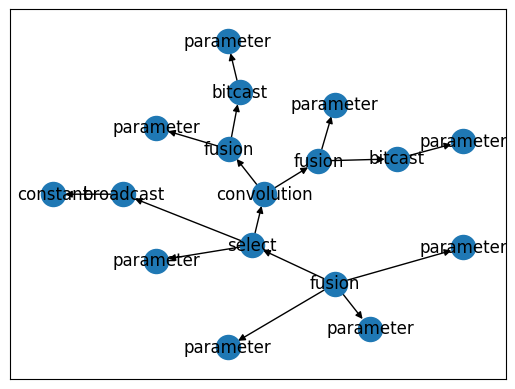

In [5]:
operations = {str(i):OPCODE_MAP[opc] for i,opc in enumerate(example['node_opcode'])}

nx.draw_networkx(graph, pos=pos, with_labels=False)
nx.draw_networkx_labels(graph, pos=pos, labels = operations);

Later when we'll start designing and engineering the features we must consider the operations that each node has, on the assumption that different operations have different impacts on the model runtime. For example a convolution is for sure an operation heavier than a broadcast.

All this `_sum` and `_product` features are respectively the sum and the product of the features. For example the `shape_dimensions_sum` is the sum of all the `shape_dimensions`.

In [6]:
NODE_FEATS = {
    0: "is_root", # - whether this node is the output",
    1: "element_size_in_bits", # - deprecated, always 0",
    # 2–20: "One hot vector of shape_element_type.",
    2: "shape_element_type_is_invalid_type",
    3: "shape_element_type_is_pred",
    4: "shape_element_type_is_s8",
    5: "shape_element_type_is_s16",
    6: "shape_element_type_is_s32",
    7: "shape_element_type_is_s64",
    8: "shape_element_type_is_u8",
    9: "shape_element_type_is_u16",
    10: "shape_element_type_is_u32",
    11: "shape_element_type_is_u64",
    12: "shape_element_type_is_f16",
    13: "shape_element_type_is_f32",
    14: "shape_element_type_is_f64",
    15: "shape_element_type_is_bf16", # https://en.wikipedia.org/wiki/Bfloat16_floating-point_format    
    16: "shape_element_type_is_c64",
    17: "shape_element_type_is_c128",
    18: "shape_element_type_is_tuple",
    19: "shape_element_type_is_opaque_type",
    20: "shape_element_type_is_token",
    # 21–28: "Size (number of elements) for each dimension, or an upper bound on the size if the dimension is dynamic.  In XLA, dimensions are numbered from 0 to N-1 for an N-dimensional array. The first element of 'shape_dimensions' is the size of dimension 0, the second element is the size of dimension 1, and so forth.  Empty list indicates a scalar.",
    21: "shape_dimensions_0",
    22: "shape_dimensions_1",
    23: "shape_dimensions_2",
    24: "shape_dimensions_3",
    25: "shape_dimensions_4",
    26: "shape_dimensions_5",
    27: "shape_dimensions_sum",
    28: "shape_dimensions_product",
    29: "shape_tuple_shapes_size", # for tuples only, the shapes of constituent shapes in the tuple sequence",
    30: "parameter_number", # = K - indicating that is is the Kth parameter to the computation, only for Parameter operation",
    # 31–36: "Dimensions present for some operations that require reshaping or broadcasting, including Reshape, Reduce, ReduceWindow, and Reverse.",
    31: "dimensions_0",
    32: "dimensions_1",
    33: "dimensions_2",
    34: "dimensions_3",
    35: "dimensions_4",
    36: "dimensions_5",
    # 37–92: "Windowing information in an operation such as convolution. The window is moved across a base area and for each position of the window a computation is performed.",
    37: "window_size_0",
    38: "window_size_1",
    39: "window_size_2",
    40: "window_size_3",
    41: "window_size_4",
    42: "window_size_5",
    43: "window_size_sum",
    44: "window_size_product",
    45: "window_stride_0",
    46: "window_stride_1",
    47: "window_stride_2",
    48: "window_stride_3",
    49: "window_stride_4",
    50: "window_stride_5",
    51: "window_stride_sum",
    52: "window_stride_product",
    53: "window_padding_low_0",
    54: "window_padding_low_1",
    55: "window_padding_low_2",
    56: "window_padding_low_3",
    57: "window_padding_low_4",
    58: "window_padding_low_5",
    59: "window_padding_low_sum",
    60: "window_padding_low_product",
    61: "window_padding_high_0",
    62: "window_padding_high_1",
    63: "window_padding_high_2",
    64: "window_padding_high_3",
    65: "window_padding_high_4",
    66: "window_padding_high_5",
    67: "window_padding_high_sum",
    68: "window_padding_high_product",
    # 69–76: "Dilation factor of the sliding window. A dilation factor of 1 means no dilation. window_dilation - 1 no-op entries ("holes") are implicitly placed between each kernel element.",
    69: "window_window_dilation_0",
    70: "window_window_dilation_1",
    71: "window_window_dilation_2",
    72: "window_window_dilation_3",
    73: "window_window_dilation_4",
    74: "window_window_dilation_5",
    75: "window_window_dilation_sum",
    76: "window_window_dilation_product",
    # 77-84: "Dilation factor of the base area. A dilation factor of 1 means no dilation. base_dilation - 1 no-op entries ("holes") are implicitly placed between each base area element.",
    77: "window_base_dilation_0",
    78: "window_base_dilation_1",
    79: "window_base_dilation_2",
    80: "window_base_dilation_3",
    81: "window_base_dilation_4",
    82: "window_base_dilation_5",
    83: "window_base_dilation_sum",
    84: "window_base_dilation_product",
    # 85-92: "Window reversal means that this dimension was logically reversed before the operation.",
    85: "window_window_reversal_0",
    86: "window_window_reversal_1",
    87: "window_window_reversal_2",
    88: "window_window_reversal_3",
    89: "window_window_reversal_4",
    90: "window_window_reversal_5",
    91: "window_window_reversal_true_count",
    92: "window_window_reversal_false_count",
    # 93–106: "The dimension numbers used for a convolution.",
    93: "convolution_dim_numbers_input_batch_dim",# - the dimension number that represents batch in the input",
    94: "convolution_dim_numbers_input_feature_dim",# - the dimension number that represents features in the input",
    # 95–98: "Dimension numbers for the spatial dimensions that the window moves through in the input.",
    95: "convolution_dim_numbers_input_spatial_dims_0",
    96: "convolution_dim_numbers_input_spatial_dims_1",
    97: "convolution_dim_numbers_input_spatial_dims_2",
    98: "convolution_dim_numbers_input_spatial_dims_3",
    99: "convolution_dim_numbers_kernel_input_feature_dim", # - the dimension number that represents input features in the convolutional kernel (rhs)",
    100: "convolution_dim_numbers_kernel_output_feature_dim", # - the dimension number that represents output features in the convolutional kernel (rhs)",
    # 101-104: "Dimension numbers for the spatial dimensions that the window moves through in the kernel (rhs). window.strides(0) is the stride in the kernel_spatial_dimensions(0) dimension.",
    101: "convolution_dim_numbers_kernel_spatial_dims_0",
    102: "convolution_dim_numbers_kernel_spatial_dims_1",
    103: "convolution_dim_numbers_kernel_spatial_dims_2",
    104: "convolution_dim_numbers_kernel_spatial_dims_3",
    105: "convolution_dim_numbers_output_batch_dim", # - the dimension number that represents batch in the output",
    106: "convolution_dim_numbers_output_feature_dim", # - the dimension number that represents features in the output",
    107: "feature_group_count", # - the number of feature groups, used for a convolution. Must be a divisor of the input feature dimension and output feature dimension. If not specified, it will use a default value of 1.",
    108: "batch_group_count", # - the number of batch groups, used for a convolution.",
    # 109–120: "[begin/start, end/limit) index range and stride for a slice operation.",
    109: "slice_dims_start_0",
    110: "slice_dims_start_1",
    111: "slice_dims_start_sum",
    112: "slice_dims_start_product",
    113: "slice_dims_stride_0",
    114: "slice_dims_stride_1",
    115: "slice_dims_stride_sum",
    116: "slice_dims_stride_product",
    117: "slice_dims_limit_0",
    118: "slice_dims_limit_1",
    119: "slice_dims_limit_sum",
    120: "slice_dims_limit_product",
    # 121 - 124: "[start, start + size) range size for a dynamic slice ('start' is specified dynamically in the second operand of the operation).",
    121: "dynamic_slice_sizes_0",
    122: "dynamic_slice_sizes_1",
    123: "dynamic_slice_sizes_sum",
    124: "dynamic_slice_sizes_product",
    # 125–132: "Padding configuration that describes the edge padding of a pad operation.",
    125: "padding_config_edge_padding_low_0",
    126: "padding_config_edge_padding_low_1",
    127: "padding_config_edge_padding_low_sum",
    128: "padding_config_edge_padding_low_product",
    129: "padding_config_edge_padding_high_0",
    130: "padding_config_edge_padding_high_1",
    131: "padding_config_edge_padding_high_sum",
    132: "padding_config_edge_padding_high_product",
    133: "is_stable", # - whether this Sort operation should be stable",
    # 134–139: "Physical layout used to pack the tensor shape.",
    134: "layout_minor_to_major_0",
    135: "layout_minor_to_major_1",
    136: "layout_minor_to_major_2",
    137: "layout_minor_to_major_3",
    138: "layout_minor_to_major_4",
    139: "layout_minor_to_major_5"
}

In [7]:
node_feats = example['node_feat']
node_feats[-2]

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 2.500e+01, 2.500e+01,
       1.024e+03, 0.000e+00, 0.000e+00, 1.078e+03, 2.560e+06, 0.000e+00,
       2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 

### Tile Config
Let's now see instead the Tile configurations and what they mean. In this example we have 8935 different configurations just for this single graph, let's pick one of them and understand it's meaning.

In [8]:
ex_configs = example['config_feat']

ex_configs.shape

(8935, 24)

In [9]:
TILE_CONFIGS = {
    # 0–7: Tile sizes of the convolution kernel, only for a convolution operation.",
    0: "kernel_bounds_0",
    1: "kernel_bounds_1",
    2: "kernel_bounds_2",
    3: "kernel_bounds_3",
    4: "kernel_bounds_4",
    5: "kernel_bounds_5",
    6: "kernel_bounds_sum",
    7: "kernel_bounds_product",
    # 8–15: Output tile sizes.",
    8: "output_bounds_0",
    9: "output_bounds_1",
    10: "output_bounds_2",
    11: "output_bounds_3",
    12: "output_bounds_4",
    13: "output_bounds_5",
    14: "output_bounds_sum",
    15: "output_bounds_product",
    # 16-23: Input tile sizes.",
    16: "input_bounds_0",
    17: "input_bounds_1",
    18: "input_bounds_2",
    19: "input_bounds_3",
    20: "input_bounds_4",
    21: "input_bounds_5",
    22: "input_bounds_sum",
    23: "input_bounds_product"
}

In [10]:
ex_configs[0]

array([ 25.,  25.,   1.,   1.,   0.,   0.,  52., 625.,   3.,   3.,  16.,
         1.,   0.,   0.,  23., 144.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.], dtype=float32)

I don't understand its meaning, or how we can interpret it.

# Baseline Model ?

We'll try to extract some basic features from each node to get the idea of how much computation is needed for each passage.

In [38]:
def node_extractor(tile):
    # this could be vectorized and made sooo much faster
    feats = pd.DataFrame(tile['node_feat']) # Nx140
    feats.columns = NODE_FEATS.values()
    
    volumes = [
        'shape_dimensions_product',
        'window_size_product',
        'window_stride_product',
        # ADD PADDING and other convolution properties
    ]
    extracted = feats[volumes].copy()
    
    extracted['op'] = pd.Series(tile['node_opcode']).map(OPCODE_MAP)
    extracted['output'] = feats['is_root']
    
    ctype = np.where(feats.iloc[:,2:20]==1)[1] +2
    
    ctype = feats.columns[ctype].str.extract(r'^.*_(?P<type>[a-z]+)(?P<bitsize>\d+)')
    extracted = pd.concat([extracted, ctype], axis=1)
        
    extracted['actions'] = extracted['shape_dimensions_product'] / extracted['window_stride_product'] * (extracted['window_size_product'])       
    return extracted

node_extractor(example)


,shape_dimensions_product,window_size_product,window_stride_product,op,output,type,bitsize,actions
0,2560000.0,1.0,1.0,parameter,0.0,bf,16,2.560000e+06
1,2560000.0,1.0,1.0,bitcast,1.0,bf,16,2.560000e+06
2,2560000.0,1.0,1.0,parameter,0.0,bf,16,2.560000e+06
3,2560000.0,1.0,1.0,bitcast,1.0,bf,16,2.560000e+06
4,9437184.0,1.0,1.0,parameter,0.0,NaN,NaN,9.437184e+06
5,2560000.0,1.0,1.0,parameter,0.0,bf,16,2.560000e+06
6,2560000.0,1.0,1.0,fusion,0.0,bf,16,2.560000e+06
7,2560000.0,1.0,1.0,parameter,0.0,bf,16,2.560000e+06
8,2560000.0,1.0,1.0,fusion,0.0,bf,16,2.560000e+06
9,9437184.0,625.0,1.0,convolution,0.0,bf,16,5.898240e+09


We note that many nodes use the `bfloat16` bit type since it was purposefully designed to make faster (but imprecise) calculations for machine learning models.

We now want to design a feature extractor for the whole tile graph.

In [ ]:
import igraph as ig

def tile_extractor(tile):
    n = tile['node_opcode'].shape[0]
    m = tile['edge_index'].shape[0]
    
    graph = ig.Graph(tile['edge_index'], directed=True)
    
    output_node = n-1 # since nodes are topological sorted we know that the output is the last node
    distances = graph.distances(source = output_node)
    avg_distance = np.mean(distances)
    max_distance = np.max(distances)
    
    return n, m, avg_distance, max_distance
    
tile_extractor(example)

(17, 16, 2.6470588235294117, 5)

In [ ]:
example['node_feat'][:,0]

array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
      dtype=float32)